Import Libraries


In [198]:
import requests
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from datetime import datetime, timedelta
import pytz
import matplotlib.pyplot as plt

In [199]:
API_KEY = '9c909306e9c168ab67cc723e8605da75'
BASE_URL = 'https://api.openweathermap.org/data/2.5/'

Fetech Current Weather Data

In [200]:
def get_current_weather(city):
    url = f"{BASE_URL}weather?q={city}&appid={API_KEY}&units=metric"
    response = requests.get(url)
    data = response.json()
    return {
        'city': data['name'],
        'current_temp': round(data['main']['temp']),
        'feels_like': round(data['main']['feels_like']),
        'temp_min': round(data['main']['temp_min']),
        'temp_max': round(data['main']['temp_max']),
        'humidity': round(data['main']['humidity']),
        'description': data['weather'][0]['description'],
        'country': data['sys']['country'],
        'wind_gust_dir': data['wind']['deg'],
        'pressure' : data['main']['pressure'],
        'Wind_Gust_Speed': data['wind']['speed']
    }

Read and Clean Historical Data

In [201]:
def read_historical_data(filename):
  df = pd.read_csv(filename)
  df = df.dropna()
  df = df.drop_duplicates()
  return df

Prepare data for taining

In [202]:
def prepare_data(data):
  le = LabelEncoder()
  data['WindGustDir'] = le.fit_transform(data['WindGustDir'])
  data['RainTomorrow'] = le.fit_transform(data['RainTomorrow'])

  X= data[['MinTemp','MaxTemp','WindGustDir','WindGustSpeed','Humidity', 'Pressure','Temp']]
  y= data['RainTomorrow']

  return X,y, le


Train the model

In [203]:
def train_rain_model(X,y):
  X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
  model = RandomForestClassifier(n_estimators=100, random_state=32)
  model.fit(X_train,y_train)

  Y_pred = model.predict(X_test)
  mse = mean_squared_error(y_test, Y_pred)
  print(f"Mean Squared Error: {mse}")
  return model

Prepare regression data

In [204]:
def preprare_regression_data(data, feature):
  X,y = [],[]
  for i in range(len(data)-1):
    X.append(data[feature].iloc[i])
    y.append(data[feature].iloc[i+1])

  X = np.array(X).reshape(-1,1)
  y = np.array(y)

  return X,y


Training Regression Model

In [205]:
def train_regression_model(X,y):
  model = RandomForestRegressor(n_estimators=100, random_state=32)
  model.fit(X,y)
  return model

Predict Future

In [206]:
def predict_future(model, current_value):
  prediction= [current_value]

  for i in range(5):
    next_value = model.predict(np.array([prediction[-1]]).reshape(-1,1))
    prediction.append(next_value[0])

  return prediction[1:]

Weather Analysis Function

In [207]:
def weather_view():
  city = input("Enter the city name: ")
  current_weather = get_current_weather(city)

  historical_data = read_historical_data('weather.csv')

  X, y, le = prepare_data(historical_data)
  rain_model = train_rain_model(X,y)

  wind_deg = current_weather['wind_gust_dir'] % 360
  compass_points = [
      ("N",0,11.25),("NNE",11.25,33.75),("NE",33.75,56.25),
      ("ENE",56.25,78.75),("E",78.75,101.25),("ESE",101.25,123.75),
      ("SE",123.75,146.25),("SSE",146.25,168.75),("S",168.75,191.25),
      ("SSW",191.25,213.75),("SW",213.75,236.25),("WSW",236.25,258.75),
      ("W",258.75,281.25),("WNW",281.25,303.75),("NW",303.75,326.25),
      ("NNW",326.25,348.75)
  ]

  compass_direction = next(
        (direction for direction, start, end in compass_points if start <= wind_deg < end),
        None
    )

  try:
    compass_direction_encoded = le.transform([compass_direction])[0]
  except ValueError:
    compass_direction_encoded = -1  # Assign a default value for unseen labels


  current_data = {
      'MinTemp' : current_weather['temp_min'],
      'MaxTemp' : current_weather['temp_max'],
      'WindGustDir' : compass_direction_encoded,
      'WindGustSpeed' : current_weather['Wind_Gust_Speed'],
      'Humidity' : current_weather['humidity'],
      'Pressure' : current_weather['pressure'],
      'Temp' : current_weather['current_temp'],
  }
  current_df = pd.DataFrame([current_data])

  rain_prediction = rain_model.predict(current_df)[0]



  X_temp, y_temp = preprare_regression_data(historical_data, 'Temp')
  X_hum, y_hum = preprare_regression_data(historical_data, 'Humidity')
  temp_model = train_regression_model(X_temp, y_temp)
  hum_model = train_regression_model(X_hum, y_hum)

  future_temp = predict_future(temp_model, current_weather['temp_min'])
  future_humidity = predict_future(hum_model, current_weather['humidity'])

  timezone = pytz.timezone('Asia/Kolkata')
  now = datetime.now(timezone)
  next_hour = now + timedelta(hours=1)
  next__hour = next_hour.replace(minute=0, second=0, microsecond=0)

  future_times = [(next_hour + timedelta(hours=i)).strftime('%H:00') for i in range(5)]

  print(f"City:{city}, {current_weather['country']}")
  print(f"Current Temperature: {current_weather['current_temp']}")
  print(f"Feels_like: {current_weather['feels_like']}")
  print(f"Minimum Temperature: {current_weather['temp_min']}C")
  print(f"Maximum Temperature: {current_weather['temp_max']}C")
  print(f"Humidity: {current_weather['humidity']}")
  print(f"Pressure: {current_weather['pressure']}")
  print(f"Wind Gust Speed: {current_weather['Wind_Gust_Speed']}")
  print(f"Weather Prediction:{current_weather['description']}")
  print(f"Rain Prediction : {'Yes' if rain_prediction else 'No'}")


  print("\n Future Temperature Predictions:")
  for time, temp in zip(future_times, future_temp):
    print(f"{time}: {temp}C")


  print("\n Future Humidity Predictions:")
  for time, humidity in zip(future_times, future_humidity):
    print(f"{time}: {humidity}%")


In [208]:
weather_view()

Enter the city name: Athens
Mean Squared Error: 0.2054794520547945
City:Athens, GR
Current Temperature: 15
Feels_like: 15
Minimum Temperature: 14C
Maximum Temperature: 16C
Humidity: 72
Pressure: 1012
Wind Gust Speed: 3.13
Weather Prediction:broken clouds
Rain Prediction : No

 Future Temperature Predictions:
14:00: 13.809134523809504C
15:00: 15.344583333333333C
16:00: 15.063158333333336C
17:00: 13.298849999999982C
18:00: 14.366297619047625C

 Future Humidity Predictions:
14:00: 64.32807142857143%
15:00: 45.218067460317464%
16:00: 46.73464935064934%
17:00: 46.54384848484849%
18:00: 46.54384848484849%


In [209]:

import matplotlib.pyplot as plt
file_path = 'weather.csv'
data = pd.read_csv(file_path)

# Calculate statistics
stats = {
    'avgTemp': round(data['Temp'].mean(), 1),
    'avgHumidity': round(data['Humidity'].mean(), 1),
    'avgPressure': round(data['Pressure'].mean(), 1),
    'maxTemp': data['MaxTemp'].max(),
    'minTemp': data['MinTemp'].min(),
    'rainDays': data[data['RainTomorrow'] == 'Yes'].shape[0],
    'totalDays': data.shape[0]
}
stats['rainProbability'] = round((stats['rainDays'] / stats['totalDays']) * 100, 1)

# Display statistics
print("Weather Statistics:")
print(f"Average Temperature: {stats['avgTemp']}°C")
print(f"Max Temperature: {stats['maxTemp']}°C")
print(f"Min Temperature: {stats['minTemp']}°C")
print(f"Average Humidity: {stats['avgHumidity']}%")
print(f"Average Pressure: {stats['avgPressure']} hPa")
print(f"Rain Days: {stats['rainDays']}")
print(f"Total Days: {stats['totalDays']}")
print(f"Rain Probability: {stats['rainProbability']}%")


Weather Statistics:
Average Temperature: 19.2°C
Max Temperature: 35.8°C
Min Temperature: -5.3°C
Average Humidity: 44.5%
Average Pressure: 1016.8 hPa
Rain Days: 66
Total Days: 366
Rain Probability: 18.0%


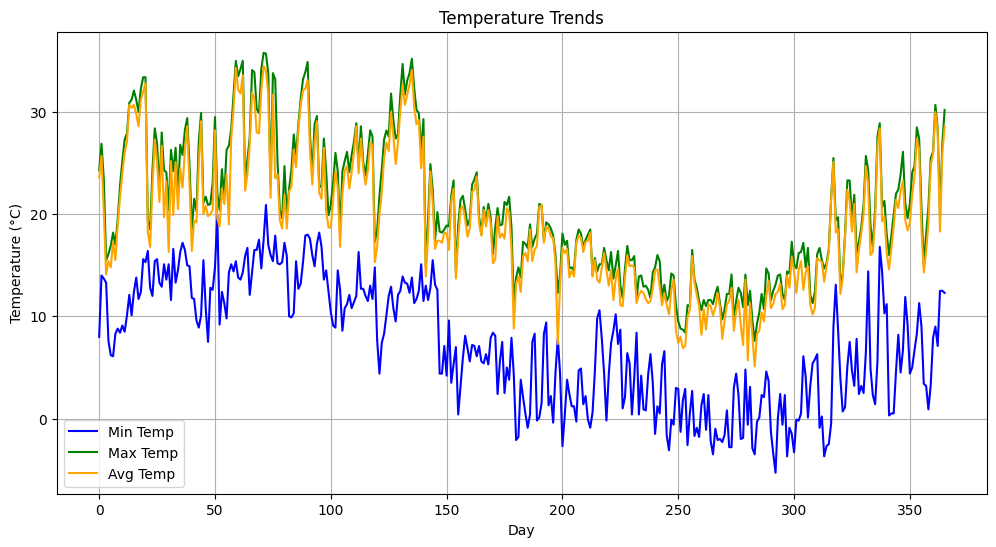

In [210]:
# Temperature trends
data['Day'] = np.arange(len(data))
plt.figure(figsize=(12, 6))
plt.plot(data['Day'], data['MinTemp'], label='Min Temp', color='blue')
plt.plot(data['Day'], data['MaxTemp'], label='Max Temp', color='green')
plt.plot(data['Day'], data['Temp'], label='Avg Temp', color='orange')
plt.title('Temperature Trends')
plt.xlabel('Day')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid()
plt.show()

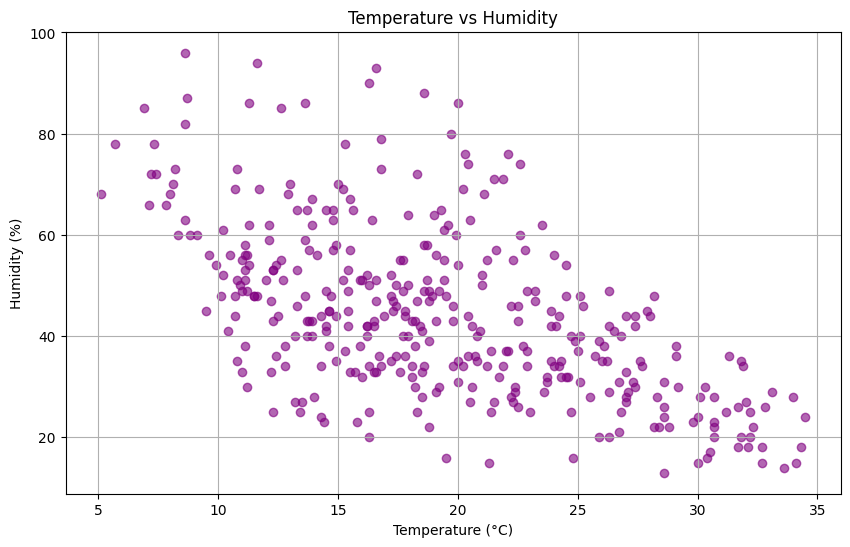

In [211]:
# Temperature vs Humidity scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(data['Temp'], data['Humidity'], color='purple', alpha=0.6)
plt.title('Temperature vs Humidity')
plt.xlabel('Temperature (°C)')
plt.ylabel('Humidity (%)')
plt.grid()
plt.show()